# ML Assignment 6 - Sample Code
* 雲端硬碟: https://drive.google.com/drive/folders/1KqXE_drqYYwg9RsQil3oXQeskXzuATdR?usp=sharing
* 蘭花競賽網站: https://tbrain.trendmicro.com.tw/Competitions/Details/20

## 執行方式
資料集請去雲端硬碟取得(./dataset)，內有壓縮檔可下載

依作業要求，在圖像轉換區塊更改程式碼。
訓練過程及輸出位於最後面。


## 初始設定

In [2]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


將剛才取得的資料集整個複製到你自己雲端上，並更改下面路徑到你自己的資料集目錄

("/content/drive/MyDrive/" 是雲端固定的位址，請自行建立資料夾，並將資料集放置在內 ex:"ML_CNN")

In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/2023 Spring/機器學習/HW6/ML_CNN
%ls

/content/drive/.shortcut-targets-by-id/1peezK-8zlx2EwsuiqR8Ll8LFWTZJCjwB/HW6/ML_CNN
dataset/  eval_loss.png  test.jpg  train_loss.png


In [6]:
from __future__ import print_function, division

import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.hub import load_state_dict_from_url
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.ion()   # interactive mode
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

## 圖像轉換
### 題目
torchvision.transforms 提供了許多可靠的 API來讓使用者對圖像進行操作，請試著在 data transforms 當中對訓練集進行轉換(圖像前處理)，當模型訓練到一定程度時，驗證看看使用該方法是否確實對模型準確率造成影響

* **Weak Augmentation** - 使用**1**種data transforms，並記錄其**使用前、使用後的validation accuracy**，共做3次

* **Strong Augmentation** - 使用**4~6**種data transforms，並記錄其**使用前、使用後的validation accuracy**

### 下面列出目前全部可用的transforms，參數部分自行Google :)



In [7]:
transforms_list = dir(transforms)
available_transforms = [name for name in transforms_list if not name.startswith("__")]
num=0
# 輸出可用的transforms函數
for transform in available_transforms:
    num+=1
    print(num,".",transform)

1 . AugMix
2 . AutoAugment
3 . AutoAugmentPolicy
4 . CenterCrop
5 . ColorJitter
6 . Compose
7 . ConvertImageDtype
8 . ElasticTransform
9 . FiveCrop
10 . GaussianBlur
11 . Grayscale
12 . InterpolationMode
13 . Lambda
14 . LinearTransformation
15 . Normalize
16 . PILToTensor
17 . Pad
18 . RandAugment
19 . RandomAdjustSharpness
20 . RandomAffine
21 . RandomApply
22 . RandomAutocontrast
23 . RandomChoice
24 . RandomCrop
25 . RandomEqualize
26 . RandomErasing
27 . RandomGrayscale
28 . RandomHorizontalFlip
29 . RandomInvert
30 . RandomOrder
31 . RandomPerspective
32 . RandomPosterize
33 . RandomResizedCrop
34 . RandomRotation
35 . RandomSolarize
36 . RandomVerticalFlip
37 . Resize
38 . TenCrop
39 . ToPILImage
40 . ToTensor
41 . TrivialAugmentWide
42 . _functional_pil
43 . _functional_tensor
44 . _presets
45 . autoaugment
46 . functional
47 . transforms


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224,224) ),
            ########在此區塊填入圖像轉換方法########
            

            ########################################
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.Resize((224,224) ),
            transforms.ToTensor(),
        ]),
    }

In [9]:
class MyCNN(nn.Module):

  def __init__(self, num_classes=1000):
    super(MyCNN, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
    )
    self.classifier2 = nn.Sequential(
      nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    x = self.classifier2(x)

    return x

## 訓練模型區塊
包含視覺化模型及訓練模型。

In [10]:
def visualize_model(model, device, dataloaders, class_names, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0

  plt.figure(figsize=(18,9))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1

        img_display = np.transpose(inputs.cpu().data[j].numpy(), (1,2,0)) #numpy:CHW, PIL:HWC
        plt.subplot(num_images//2,2,images_so_far),plt.imshow(img_display) #nrow,ncol,image_idx
        plt.title(f'predicted: {class_names[preds[j]]}')
        plt.savefig("test.jpg")
        if images_so_far == num_images:
            model.train(mode=was_training)
            plt.clf()
            return
    plt.clf()
    model.train(mode=was_training)

def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  
  #原先Normalize是對每個channel個別做 減去mean, 再除上std
  inp1 = std * inp + mean

  plt.imshow(inp)

  if title is not None:
      plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  plt.imshow(inp1)
  if title is not None:
      plt.title(title)
  plt.clf()


def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())


  plt.figure(0)
  plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./train_loss.png")
  plt.clf()

  plt.figure(1)
  plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./eval_loss.png")
  plt.clf()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  #torch.save(model.state_dict(),"model.pt")
  return model

## 訓練參數
* num_epochs: 訓練回合數
* lr: 訓練速度(learning rate)
* batch_size: 批次(batch)大小

In [12]:
num_epochs = 20
lr = 0.001
batch_size = 64

## 主函式

Using device cuda:0



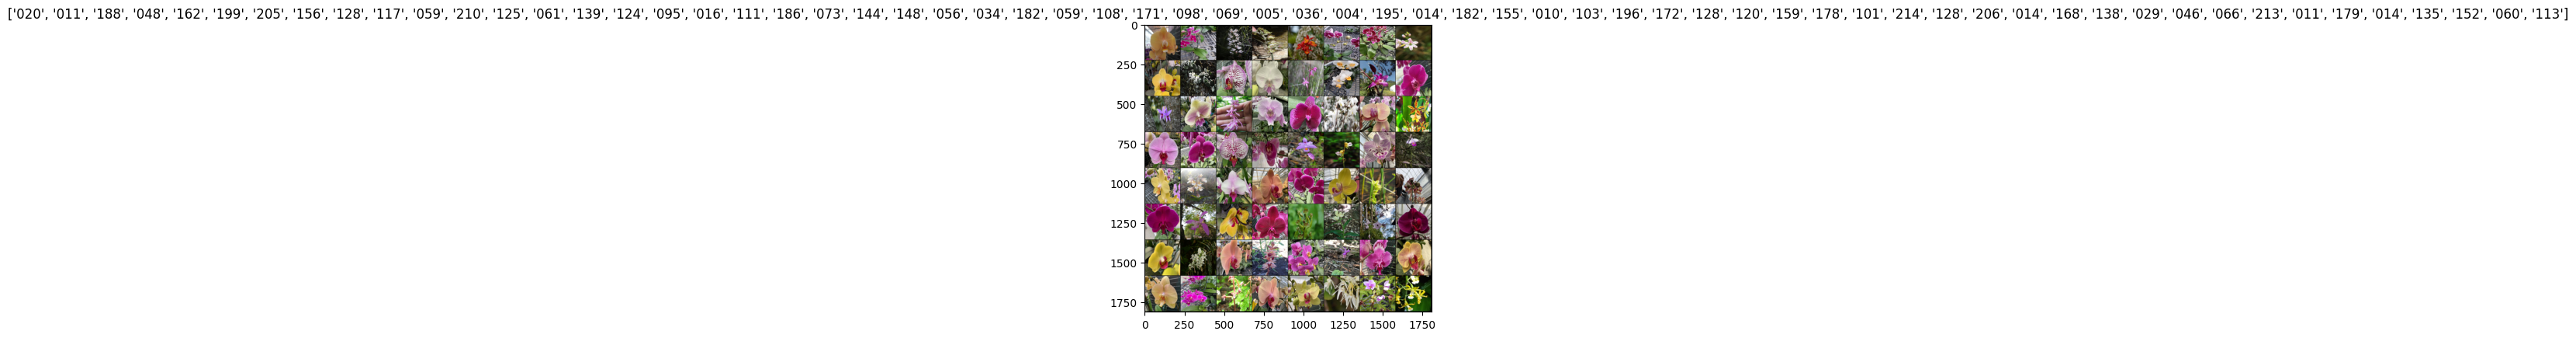

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 98.9MB/s]


features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier2.0.weight
classifier2.0.bias
#parameters:57901083
batch_size:64
Epoch 1/20
----------


100%|██████████| 24/24 [02:31<00:00,  6.29s/it]


train Loss: 5.3960 Acc: 0.0085


100%|██████████| 11/11 [01:02<00:00,  5.71s/it]


val Loss: 5.0750 Acc: 0.0578
Epoch 2/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


train Loss: 4.7088 Acc: 0.0978


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


val Loss: 4.0406 Acc: 0.2040
Epoch 3/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


train Loss: 3.4255 Acc: 0.2114


100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


val Loss: 3.0237 Acc: 0.2861
Epoch 4/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


train Loss: 2.2405 Acc: 0.4214


100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


val Loss: 2.5432 Acc: 0.3501
Epoch 5/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


train Loss: 1.5589 Acc: 0.5864


100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


val Loss: 2.3142 Acc: 0.4490
Epoch 6/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


train Loss: 1.0678 Acc: 0.6993


100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


val Loss: 2.1474 Acc: 0.4521
Epoch 7/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


train Loss: 0.7235 Acc: 0.7873


100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


val Loss: 2.2065 Acc: 0.4764
Epoch 8/20
----------


100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


train Loss: 0.4069 Acc: 0.8950


100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


val Loss: 1.9373 Acc: 0.5434
Epoch 9/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


train Loss: 0.2658 Acc: 0.9367


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


val Loss: 1.9075 Acc: 0.5358
Epoch 10/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


train Loss: 0.2095 Acc: 0.9556


100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


val Loss: 1.9245 Acc: 0.5403
Epoch 11/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


train Loss: 0.1762 Acc: 0.9609


100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


val Loss: 1.9196 Acc: 0.5464
Epoch 12/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


train Loss: 0.1559 Acc: 0.9693


100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


val Loss: 1.9346 Acc: 0.5571
Epoch 13/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


train Loss: 0.1665 Acc: 0.9550


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


val Loss: 1.9672 Acc: 0.5419
Epoch 14/20
----------


100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


train Loss: 0.1530 Acc: 0.9667


100%|██████████| 11/11 [00:06<00:00,  1.68it/s]


val Loss: 1.9820 Acc: 0.5556
Epoch 15/20
----------


100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


train Loss: 0.1444 Acc: 0.9700


100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


val Loss: 1.9792 Acc: 0.5586
Epoch 16/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


train Loss: 0.1334 Acc: 0.9759


100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


val Loss: 1.9739 Acc: 0.5556
Epoch 17/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


train Loss: 0.1303 Acc: 0.9752


100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


val Loss: 1.9776 Acc: 0.5540
Epoch 18/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


train Loss: 0.1303 Acc: 0.9765


100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


val Loss: 1.9823 Acc: 0.5540
Epoch 19/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


train Loss: 0.1192 Acc: 0.9804


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


val Loss: 1.9854 Acc: 0.5525
Epoch 20/20
----------


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


train Loss: 0.1300 Acc: 0.9733


100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


val Loss: 1.9864 Acc: 0.5525
Training complete in 9m 23s
Best val Acc: 0.558600


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1800x900 with 0 Axes>

In [13]:
def main():
  num_workers = 2
  momentum = 0.9

  # 資料集載入 =======================================================================
  data_dir = './dataset/training'
  image_datasets = {
    x: datasets.ImageFolder(
      os.path.join(data_dir, x),
      data_transforms[x]
    ) 
    for x in ['train', 'val']
  }
  dataloaders = {
    x: torch.utils.data.DataLoader(
      image_datasets[x], 
      batch_size=batch_size,
      shuffle=True, 
      num_workers=num_workers
    )
    for x in ['train', 'val']
  }
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes
  # 資料集載入 =======================================================================

  # 設定 CUDA 環境 =======================================================================
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Using device {device}\n")
  # 設定 CUDA 環境 =======================================================================


  # Get a batch of training data
  inputs, classes = next(iter(dataloaders['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

  
  # model =======================================================================
  model_ft = MyCNN(num_classes=219)
  pretrained_dict = load_state_dict_from_url(
    'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    progress=True
  )
  model_dict = model_ft.state_dict()
  # 1. filter out unnecessary keys
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
  # 2. overwrite entries in the existing state dict
  model_dict.update(pretrained_dict) 
  # 3. load the new state dict
  model_ft.load_state_dict(model_dict)

  for k,v in model_dict.items():
    print(k)

  model_ft = model_ft.to(device)
  # model =======================================================================

  parameter_count = count_parameters(model_ft)
  print(f"#parameters:{parameter_count}")
  print(f"batch_size:{batch_size}")


  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(
    model_ft, 
    criterion, 
    device, 
    dataloaders, 
    dataset_sizes, 
    optimizer_ft, 
    exp_lr_scheduler,     
    num_epochs=num_epochs
  )

  visualize_model(model_ft, device, dataloaders, class_names)

if __name__ == '__main__':
    main()